In [1]:
#!pip install lifelines
#!pip download lifelines -d ./kaggle/working/

!pip install --no-index --find-links=./kaggle/working/packages lifelines

Looking in links: ./kaggle/working/packages
ERROR: Could not find a version that satisfies the requirement lifelines (from versions: none)
ERROR: No matching distribution found for lifelines


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# import textwrap

from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv',
                       index_col='ID')
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv',
                      index_col='ID')
data_dictionary = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv',
                                index_col='ID')

In [5]:
duration_col = 'efs_time'
event_col = 'efs'

#
df_train_features = df_train.drop(columns=[duration_col, event_col])
train_durations = df_train[duration_col].values
train_events = df_train[event_col].values
#
df_test_features = df_test.copy()

categorical_cols = data_dictionary[data_dictionary['type'] == 'Categorical']['variable'].values
numerical_cols = data_dictionary[data_dictionary['type'] == 'Numerical']['variable'].values
categorical_cols = categorical_cols[categorical_cols != 'efs']
numerical_cols = numerical_cols[numerical_cols != 'efs_time']

# Filling NAs with mode values
for col in categorical_cols:
    mode = df_train_features[col].mode()[0]
    df_train_features.fillna({col: mode}, inplace=True)
    df_test_features.fillna({col: mode}, inplace=True)

# Data encoding
encoder = OrdinalEncoder()
df_train_features[categorical_cols] = encoder.fit_transform(df_train_features[categorical_cols])
df_test_features[categorical_cols] = encoder.transform(df_test_features[categorical_cols])

imputer = KNNImputer(n_neighbors=5, weights="uniform")
#
df_train_features_imputed = imputer.fit_transform(df_train_features)
df_train_features = pd.DataFrame(df_train_features_imputed,
                                 columns=df_train_features.columns,
                                 index=df_train_features.index)
#
df_test_features_imputed = imputer.transform(df_test_features)
df_test_features = pd.DataFrame(df_test_features_imputed,
                            columns=df_test_features.columns,
                            index=df_test_features.index)

scaler = MinMaxScaler()
#
df_train_features_scaled = scaler.fit_transform(df_train_features)
df_train_features = pd.DataFrame(df_train_features_scaled,
                                 columns=df_train_features.columns,
                                 index=df_train_features.index)
#
df_test_features_scaled = scaler.transform(df_test_features)
df_test_features = pd.DataFrame(df_test_features_scaled,
                            columns=df_test_features.columns,
                            index=df_test_features.index)

pca = PCA(n_components=50)
#
df_train_features_pca = pca.fit_transform(df_train_features)
df_train_features = pd.DataFrame(data=df_train_features_pca,
                                 columns=[f'component_{i+1}' for i in range(50)],
                                 index=df_train_features.index)
df_train_prep = df_train_features.copy()
df_train_prep[duration_col] = train_durations
df_train_prep[event_col] = train_events
#
df_test_features_pca = pca.transform(df_test_features)
df_test_features = pd.DataFrame(data=df_test_features_pca,
                                columns=[f'component_{i+1}' for i in range(50)],
                                index=df_test_features.index)
df_test_prep = df_test_features.copy()

In [6]:
cph = CoxPHFitter()
cph.fit(df_train_prep, duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 28800 total observations, 13268 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 28800
number of events observed = 15532
   partial log-likelihood = -151998.63
         time fit was run = 2025-02-04 05:50:33 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
component_1  -0.04      0.96      0.01           -0.06           -0.03                0.94                0.98
component_2  -0.59      0.56      0.01           -0.61           -0.56                0.54                0.57
component_3  -0.00      1.00      0.02           -0.04            0.03                0.96                1.03
component_4   0.13      1.14      0.02            0.09            0.16                1.09                1.18
component_5   0.14      1.15      0.02            0.10            0.18                1.11                1.19
component_6  -0.10      0.90      0.02           -0.14           -0.06                0.87                0.94
component_7   0.17      1.19      0.02            0.13            0.21                1.14                1.23
component_8   0.00      1.00      0.02           -0.04            0.04                0.96                1.04
component_9  -0.27      0.77      0.02           -0.31           -0.22                0.73                0.80
component_10  0.05      1.05      0.02            0.00            0.09                1.00                1.10
component_11  0.01      1.01      0.02           -0.04            0.05                0.96                1.05
component_12  0.02      1.02      0.02           -0.02            0.07                0.98                1.07
component_13  0.12      1.12      0.02            0.07            0.16                1.07                1.18
component_14 -0.17      0.85      0.02           -0.21           -0.12                0.81                0.89
component_15  0.31      1.36      0.03            0.26            0.36                1.29                1.43
component_16 -0.32      0.72      0.03           -0.37           -0.27                0.69                0.76
component_17  0.33      1.39      0.03            0.27            0.39                1.31                1.47
component_18 -0.65      0.52      0.03           -0.71           -0.59                0.49                0.56
component_19  0.12      1.13      0.03            0.06            0.18                1.06                1.20
component_20  0.13      1.14      0.03            0.07            0.19                1.07                1.21
component_21 -0.26      0.77      0.03           -0.32           -0.20                0.72                0.82
component_22  0.01      1.01      0.03           -0.06            0.08                0.95                1.08
component_23 -0.11      0.90      0.03           -0.17           -0.04                0.84                0.96
component_24  0.36      1.44      0.03            0.30            0.43                1.35                1.53
component_25  0.29      1.34      0.03            0.23            0.36                1.26                1.43
component_26 -0.29      0.75      0.04           -0.37           -0.22                0.69                0.80
component_27 -0.21      0.81      0.04           -0.29           -0.13                0.75                0.88
component_28 -0.08      0.92      0.04           -0.16           -0.01                0.85                0.99
component_29 -0.33      0.72      0.04           -0.40           -0.26                0.67                0.77
component_30  0.27      1.31      0.04            0.20            0.34                1.22                1.41
component_31 -0.08      0.93      0.04           -0.16            0.00        

<Axes: >

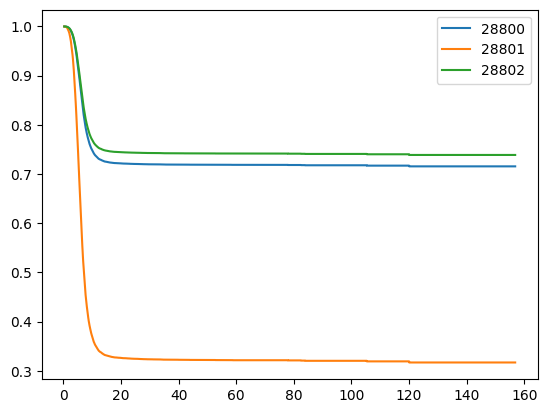

In [7]:
cph.predict_survival_function(df_test_prep).plot()

In [8]:
cph.predict_partial_hazard(df_test_prep)

28800    0.438822
28801    1.507108
28802    0.396979
dtype: float64

In [9]:
sample_submission['prediction'] = cph.predict_partial_hazard(df_test_prep)
sample_submission.to_csv('/kaggle/working/submission.csv')